In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Fri Jan 12 17:20:17 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   24C    P8    15W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.latent_layer.sampling_uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.0202789306640625
encoder.convs 5.989013671875
encoder.linear 0.0312652587890625
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.12-4/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 39492
-rw-rw-r-- 1 scpark scpark   217604  1월 12 17:20 events.out.tfevents.1705047492.GPUSVR01
-rw-rw-r-- 1 scpark scpark 38023101  1월 12 17:18 save_0
-rw-rw-r-- 1 scpark scpark   440420  1월 12 17:18 events.out.tfevents.1705047249.GPUSVR01
-rw-rw-r-- 1 scpark scpark   677348  1월 12 17:14 events.out.tfevents.1705046891.GPUSVR01
-rw-rw-r-- 1 scpark scpark   496772  1월 12 17:08 events.out.tfevents.1705046622.GPUSVR01
-rw-rw-r-- 1 scpark scpark   447908  1월 12 17:03 events.out.tfevents.1705046381.GPUSVR01
-rw-rw-r-- 1 scpark scpark   121220  1월 12 16:59 events.out.tfevents.1705046299.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


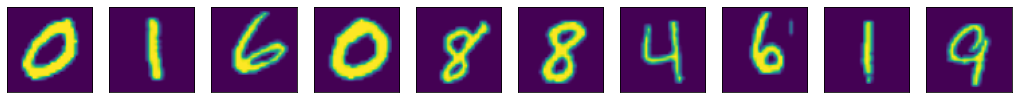

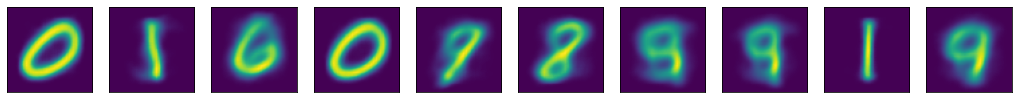

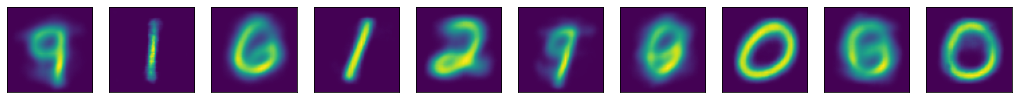

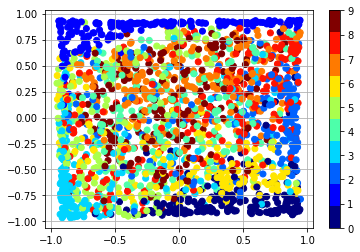

124001
lse_loss 0.9017727971076965
recon_loss 0.16589266061782837
124002
lse_loss 0.9062321186065674
recon_loss 0.15305131673812866
124003
lse_loss 0.9239762425422668
recon_loss 0.16217754781246185
124004
lse_loss 0.9795987010002136
recon_loss 0.1517726182937622
124005
lse_loss 0.9626436233520508
recon_loss 0.1632981151342392
124006
lse_loss 0.8415096998214722
recon_loss 0.1536865532398224
124007
lse_loss 0.7561125159263611
recon_loss 0.15652059018611908
124008
lse_loss 0.9299128651618958
recon_loss 0.1699112057685852
124009
lse_loss 0.8983182311058044
recon_loss 0.16342566907405853
124010
lse_loss 0.9456166625022888
recon_loss 0.15705613791942596
124011
lse_loss 0.8487036824226379
recon_loss 0.15896478295326233
124012
lse_loss 0.8918789029121399
recon_loss 0.166229709982872
124013
lse_loss 0.8899110555648804
recon_loss 0.16556888818740845
124014
lse_loss 0.8249886631965637
recon_loss 0.1713062971830368
124015
lse_loss 0.9315996766090393
recon_loss 0.16175538301467896
124016
lse_loss 0

124129
lse_loss 1.2069755792617798
recon_loss 0.16124053299427032
124130
lse_loss 1.0602302551269531
recon_loss 0.1727803647518158
124131
lse_loss 1.0995380878448486
recon_loss 0.16250300407409668
124132
lse_loss 1.1067636013031006
recon_loss 0.16253802180290222
124133
lse_loss 0.948792576789856
recon_loss 0.15820658206939697
124134
lse_loss 0.9829552173614502
recon_loss 0.16557136178016663
124135
lse_loss 1.0654391050338745
recon_loss 0.14946645498275757
124136
lse_loss 1.0343140363693237
recon_loss 0.1622309684753418
124137
lse_loss 0.9414728283882141
recon_loss 0.16157880425453186
124138
lse_loss 0.9594809412956238
recon_loss 0.16295266151428223
124139
lse_loss 0.8667097687721252
recon_loss 0.15368884801864624
124140
lse_loss 0.8961788415908813
recon_loss 0.1585906594991684
124141
lse_loss 0.9211971759796143
recon_loss 0.15469275414943695
124142
lse_loss 0.8014513850212097
recon_loss 0.1587214320898056
124143
lse_loss 0.7426071166992188
recon_loss 0.1634635627269745
124144
lse_loss 

124254
lse_loss 0.8256073594093323
recon_loss 0.1528947651386261
124255
lse_loss 0.9343728423118591
recon_loss 0.16085773706436157
124256
lse_loss 0.7500210404396057
recon_loss 0.16285991668701172
124257
lse_loss 0.9228125214576721
recon_loss 0.1618105173110962
124258
lse_loss 1.0201375484466553
recon_loss 0.16448037326335907
124259
lse_loss 1.0085166692733765
recon_loss 0.1644102782011032
124260
lse_loss 1.0375323295593262
recon_loss 0.15103110671043396
124261
lse_loss 0.8629037141799927
recon_loss 0.15576130151748657
124262
lse_loss 0.8549856543540955
recon_loss 0.15416382253170013
124263
lse_loss 0.8925893306732178
recon_loss 0.15870335698127747
124264
lse_loss 0.9044422507286072
recon_loss 0.16762149333953857
124265
lse_loss 0.8597717881202698
recon_loss 0.14925217628479004
124266
lse_loss 1.0035909414291382
recon_loss 0.15763263404369354
124267
lse_loss 0.8965778946876526
recon_loss 0.15320956707000732
124268
lse_loss 0.8647096753120422
recon_loss 0.1634480059146881
124269
lse_los

124383
lse_loss 1.0413618087768555
recon_loss 0.1570698618888855
124384
lse_loss 0.8559735417366028
recon_loss 0.15635626018047333
124385
lse_loss 1.0011872053146362
recon_loss 0.16149690747261047
124386
lse_loss 0.8170272707939148
recon_loss 0.17202508449554443
124387
lse_loss 0.8079538345336914
recon_loss 0.1664787083864212
124388
lse_loss 0.8789524435997009
recon_loss 0.15752379596233368
124389
lse_loss 0.9648661613464355
recon_loss 0.16558310389518738
124390
lse_loss 1.0297235250473022
recon_loss 0.1655150055885315
124391
lse_loss 0.9370775818824768
recon_loss 0.1701057404279709
124392
lse_loss 0.8372883200645447
recon_loss 0.1812899112701416
124393
lse_loss 0.7389059066772461
recon_loss 0.15519529581069946
124394
lse_loss 0.9918484091758728
recon_loss 0.16490596532821655
124395
lse_loss 0.9153113961219788
recon_loss 0.16230687499046326
124396
lse_loss 0.8558904528617859
recon_loss 0.1819756031036377
124397
lse_loss 0.9530747532844543
recon_loss 0.15526504814624786
124398
lse_loss 

KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=6e-2)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-2)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z_mean'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        